# Loss and Accuarcy over Epochs

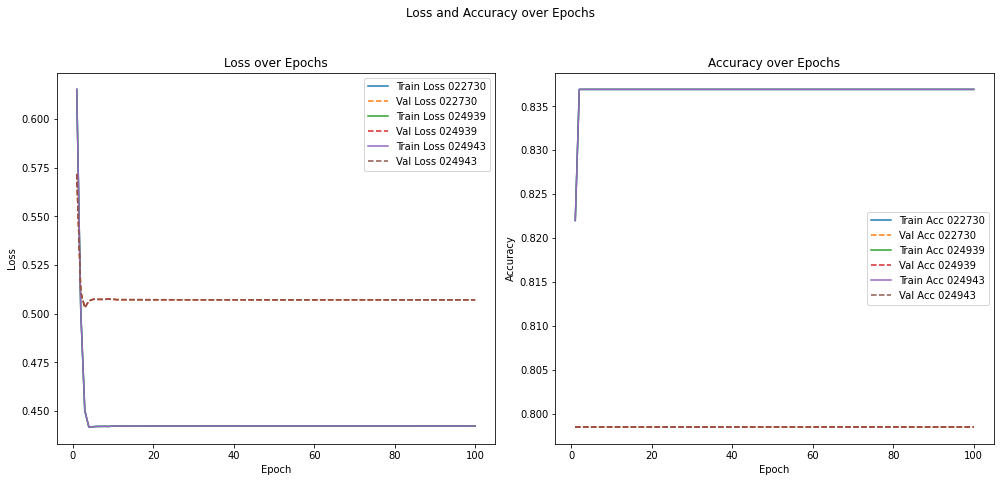

In [4]:
import glob
import matplotlib.pyplot as plt
import json

# Assuming the JSON files are stored in the directory '/mnt/data/results/'
# Using the glob module to find all json files in the specified directory
file_list = glob.glob('results/metrics_*.json')

# Initialize a dictionary to store the data for each metric
metrics_data = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Initialize a list for epochs (assuming all files will have the same number of epochs)
epochs = []

# Initialize a list to store the timestamps for legend labeling
timestamps = []

# Process each file
for file in file_list:
    # Extract timestamp from the file name
    timestamp = file.split('_')[-1].split('.')[0]
    timestamps.append(timestamp)
    
    # Read json content
    with open(file, 'r') as f:
        data = json.load(f)
        
    # Append the data from this file to the metrics_data dictionary
    for key in metrics_data:
        metrics_data[key].append(data[key])

    # Assuming all files have the same number of epochs, we only need to set this once
    if not epochs:
        epochs = list(range(1, len(data['train_loss']) + 1))

# Plot the data
plt.figure(figsize=(14, 7))

# Subplot for Loss
plt.subplot(1, 2, 1)
for i, timestamp in enumerate(timestamps):
    plt.plot(epochs, metrics_data['train_loss'][i], label=f'Train Loss {timestamp}')
    plt.plot(epochs, metrics_data['val_loss'][i], label=f'Val Loss {timestamp}', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot for Accuracy
plt.subplot(1, 2, 2)
for i, timestamp in enumerate(timestamps):
    plt.plot(epochs, metrics_data['train_acc'][i], label=f'Train Acc {timestamp}')
    plt.plot(epochs, metrics_data['val_acc'][i], label=f'Val Acc {timestamp}', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle('Loss and Accuracy over Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
